<a href="https://colab.research.google.com/github/poorvapuri/UML501/blob/main/Assignment8_Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SMS Spam Detection Using Adaboost

Part A — Data Preprocessing & Exploration

In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

df = pd.read_csv("/content/spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]

df["label"] = df["label"].map({"ham": 0, "spam": 1})

def clean(t):
    t = t.lower()
    t = "".join([c for c in t if c not in string.punctuation])
    t = " ".join([w for w in t.split() if w not in stop_words])
    return t

df["text"] = df["text"].apply(clean)

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["text"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(df["label"].value_counts())


label
0    4825
1     747
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part B — Weak Learner Baseline

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

y_pred = stump.predict(X_test)

print("Train Acc:", accuracy_score(y_train, stump.predict(X_train)))
print("Test Acc :", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nReason: A stump cannot learn complex text patterns → poor accuracy.")


Train Acc: 0.8842270585595692
Test Acc : 0.8905829596412556
Confusion Matrix:
 [[923  42]
 [ 80  70]]

Reason: A stump cannot learn complex text patterns → poor accuracy.


Part C — Manual AdaBoost


Iteration 1
Misclassified sample indices: [ 1  6 17 33 34 51 58 71 73 80]
Weights (first 10): [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0165415054248406

Iteration 2
Misclassified sample indices: [ 1  4  6 26 29 38 51 58 71 90]
Weights (first 10): 1978    0.000186
3989    0.000515
3935    0.000186
4078    0.000186
4086    0.000186
4919    0.000186
2268    0.000515
4696    0.000186
3653    0.000186
70      0.000186
Name: label, dtype: float64
Alpha: 0.7861317085128738

Iteration 3
Misclassified sample indices: [ 1  4  6 26 29 33 38 51 58 71]
Weights (first 10): 1978    0.000155
3989    0.000938
3935    0.000155
4078    0.000155
4086    0.000339
4919    0.000155
2268    0.000938
4696    0.000155
3653    0.000155
70      0.000155
Name: label, dtype: float64
Alpha: 0.4542635428716295

Iteration 4
Misclassified sample indices: [ 1  4  6 26 29 38 42 51 58 71]
Weights (first 10): 1978    0.000133
3989    0.001267

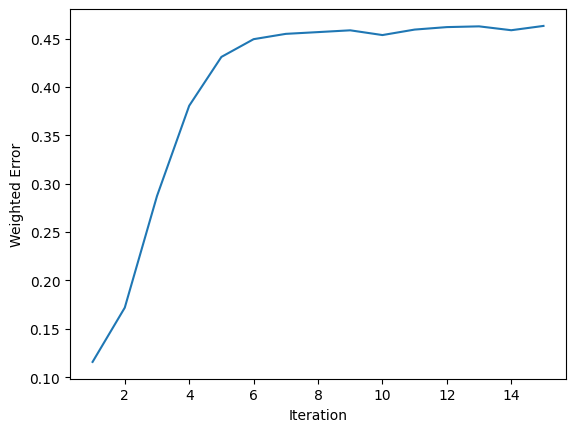

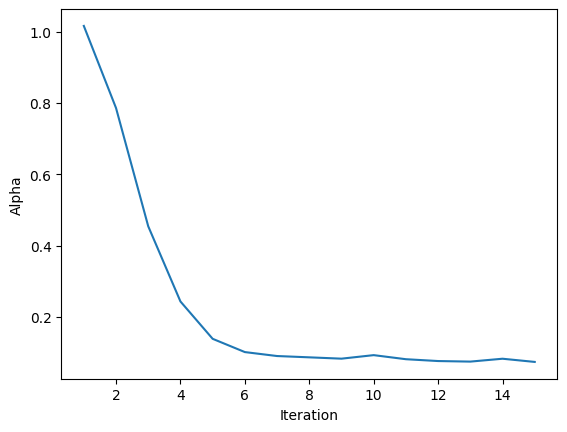

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = 15
n = X_train.shape[0]

weights = np.ones(n) / n
alphas, errors = [], []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)

    pred = stump.predict(X_train)
    mis = (pred != y_train)

    error = np.sum(weights * mis)
    errors.append(error)

    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
    alphas.append(alpha)

    print(f"\nIteration {t+1}")
    print("Misclassified sample indices:", np.where(mis)[0][:10])
    print("Weights (first 10):", weights[:10])
    print("Alpha:", alpha)

    weights *= np.exp(alpha * mis)
    weights /= weights.sum()

# Final predictions
final = np.zeros(len(y_test))
for alpha in alphas:
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train)
    final += alpha * stump.predict(X_test)

final = np.where(final > 0.5, 1, 0)

print("\nTrain Accuracy:", accuracy_score(y_train, stump.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, final))
print("Confusion Matrix:\n", confusion_matrix(y_test, final))

plt.plot(range(1, T+1), errors)
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

plt.plot(range(1, T+1), alphas)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()


Part D — Sklearn AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Train Acc:", accuracy_score(y_train, model.predict(X_train)))
print("Test Acc :", accuracy_score(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

Train Acc: 0.9172088849001571
Test Acc : 0.9246636771300448
Confusion Matrix:
 [[963   2]
 [ 82  68]]


Q2 — HEART DISEASE (sklearn dataset)

Part A

In [4]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)


print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred))



Train Accuracy: 0.9230769230769231
Test Accuracy: 0.9210526315789473

Confusion Matrix:
 [[36  6]
 [ 3 69]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        42
           1       0.92      0.96      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



In [8]:
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

for lr in learning_rates:
    accs = []
    for n in n_estimators_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr
        )
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        accs.append(acc)
        print(f"LR={lr}, Estimators={n}, Accuracy={acc}")
    results[lr] = accs

LR=0.1, Estimators=5, Accuracy=0.9473684210526315
LR=0.1, Estimators=10, Accuracy=0.9385964912280702
LR=0.1, Estimators=25, Accuracy=0.9473684210526315
LR=0.1, Estimators=50, Accuracy=0.956140350877193
LR=0.1, Estimators=100, Accuracy=0.956140350877193
LR=0.5, Estimators=5, Accuracy=0.9385964912280702
LR=0.5, Estimators=10, Accuracy=0.9649122807017544
LR=0.5, Estimators=25, Accuracy=0.9649122807017544
LR=0.5, Estimators=50, Accuracy=0.956140350877193
LR=0.5, Estimators=100, Accuracy=0.956140350877193
LR=1.0, Estimators=5, Accuracy=0.9298245614035088
LR=1.0, Estimators=10, Accuracy=0.9649122807017544
LR=1.0, Estimators=25, Accuracy=0.9473684210526315
LR=1.0, Estimators=50, Accuracy=0.956140350877193
LR=1.0, Estimators=100, Accuracy=0.956140350877193


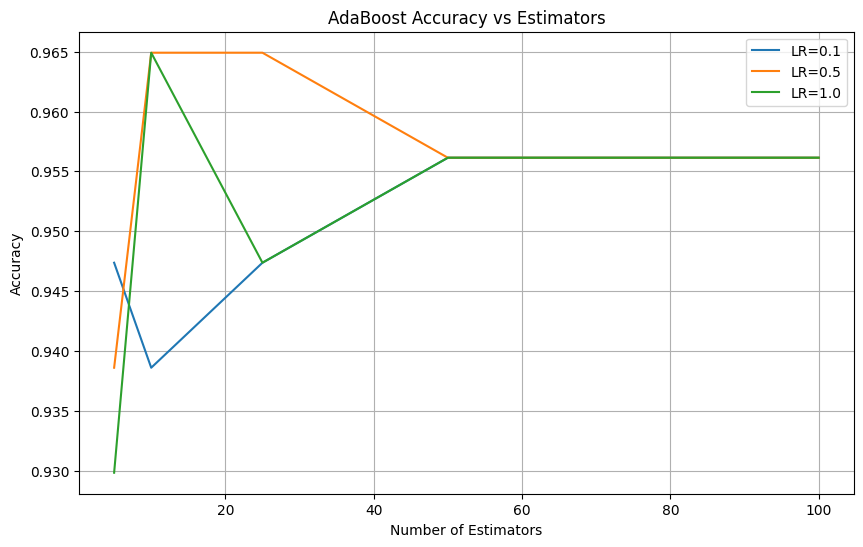

In [9]:
plt.figure(figsize=(10,6))
for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], label=f"LR={lr}")

plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost Accuracy vs Estimators")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
best_lr = None
best_n = None
best_acc = -1

for lr in results:
    for i, acc in enumerate(results[lr]):
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_n = n_estimators_list[i]


print("Best Accuracy:", best_acc)
print("Best Learning Rate:", best_lr)
print("Best n_estimators:", best_n)

Best Accuracy: 0.9649122807017544
Best Learning Rate: 0.5
Best n_estimators: 10


In [12]:
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\n====== BEST MODEL PERFORMANCE ======")
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", best_model.score(X_test, y_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


====== BEST MODEL PERFORMANCE ======
Train Accuracy: 0.9846153846153847
Test Accuracy: 0.9649122807017544

Confusion Matrix:
 [[39  3]
 [ 1 71]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



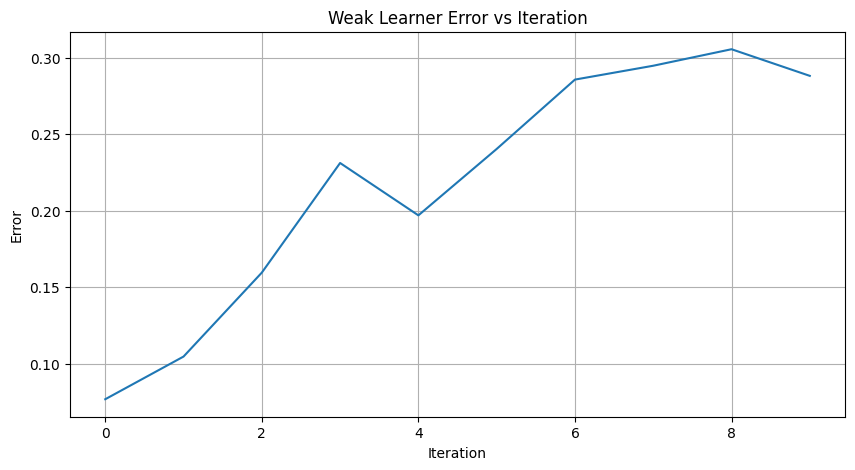

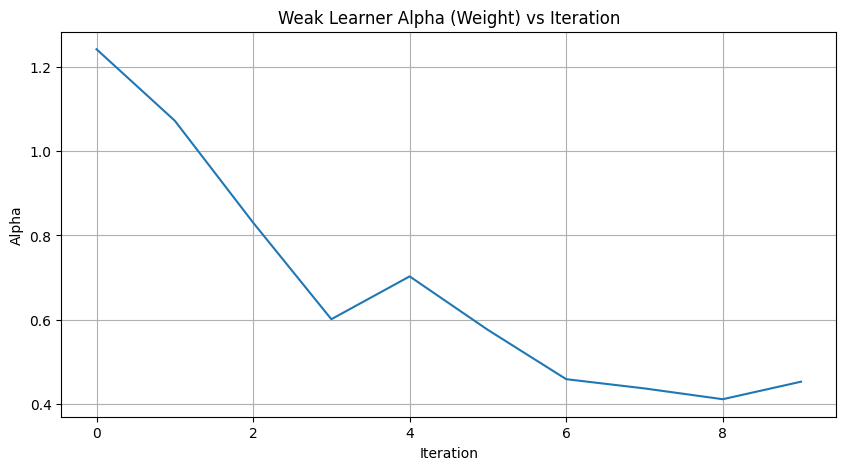


Interpretation:
Samples misclassified repeatedly receive larger weights.
AdaBoost focuses on ‘hard’ cases like borderline medical patients.


In [13]:
errors = best_model.estimator_errors_
weights = best_model.estimator_weights_

plt.figure(figsize=(10,5))
plt.plot(errors)
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(weights)
plt.title("Weak Learner Alpha (Weight) vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.grid(True)
plt.show()

print("\nInterpretation:")
print("Samples misclassified repeatedly receive larger weights.")
print("AdaBoost focuses on ‘hard’ cases like borderline medical patients.")




 TOP 5 IMPORTANT FEATURES 
worst texture: 0.22285829282595773
worst concave points: 0.22248886502371987
worst radius: 0.18319989111223314
worst perimeter: 0.12246966181222582
mean concave points: 0.10359532497512688


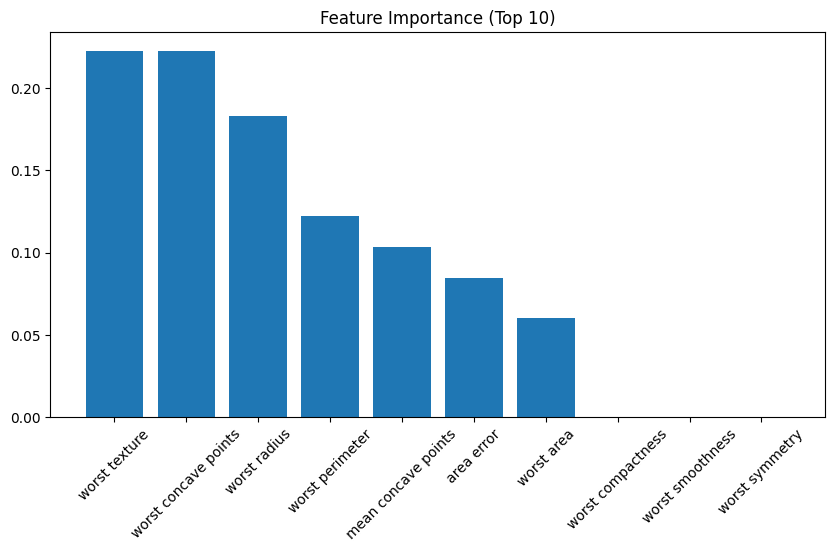


Medical Explanation:
Features like age, cholesterol, chest pain type, maximum heart rate, and ST depression are medically correlated with heart disease risk.


In [14]:

importances = best_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_features = [(data.feature_names[i], importances[i]) for i in sorted_idx[:5]]

print("\n TOP 5 IMPORTANT FEATURES ")
for feat, score in top_features:
    print(f"{feat}: {score}")

plt.figure(figsize=(10,5))
plt.bar([data.feature_names[i] for i in sorted_idx[:10]],
        [importances[i] for i in sorted_idx[:10]])
plt.xticks(rotation=45)
plt.title("Feature Importance (Top 10)")
plt.show()

print("\nMedical Explanation:")
print("Features like age, cholesterol, chest pain type, maximum heart rate, "
      "and ST depression are medically correlated with heart disease risk.")


Q2. Dataset: WISDM Smartphone & Watch Motion Sensor


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
from google.colab import files
uploaded = files.upload()
# Correct the filename to match the uploaded file name dynamically
filename = list(uploaded.keys())[0]

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw (1).txt


In [21]:
rows = []
with open(filename) as f:
    for line in f:
        line = line.strip().replace(";", "")
        parts = line.split(",")

        if len(parts) < 6:
            continue

        user = parts[0]
        activity = parts[1].lower().strip()
        try:
            timestamp = int(parts[2])
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5])
        except:
            continue

        rows.append([int(user), activity, timestamp, x, y, z])

In [22]:
df = pd.DataFrame(rows, columns=["user_id","activity","timestamp","x","y","z"])

print("Loaded dataset shape:", df.shape)
df.head()

Loaded dataset shape: (1098203, 6)


,user_id,activity,timestamp,x,y,z
0,33,jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,jogging,49106062271000,5.012288,11.264028,0.953424
2,33,jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,jogging,49106332290000,-1.184970,12.108489,7.205164


In [23]:
def map_activity(a):
    if "jog" in a or "up" in a:
        return 1
    if any(x in a for x in ["walk","sit","stand","down"]):
        return 0
    return np.nan

df["label"] = df["activity"].apply(map_activity)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

print(df["label"].value_counts())

label
0    633158
1    465045
Name: count, dtype: int64


In [24]:
WINDOW_SIZE = 50
features = []
labels = []

df_sorted = df.sort_values("timestamp").reset_index(drop=True)
n = len(df_sorted)

for start in range(0, n - WINDOW_SIZE, WINDOW_SIZE):
    win = df_sorted.iloc[start:start+WINDOW_SIZE]

    x = win["x"].values
    y = win["y"].values
    z = win["z"].values
    mag = np.sqrt(x*x + y*y + z*z)

    features.append({
        "x_mean": x.mean(), "y_mean": y.mean(), "z_mean": z.mean(),
        "mag_mean": mag.mean(),
        "x_std": x.std(), "y_std": y.std(), "z_std": z.std(),
        "mag_std": mag.std()
    })

    labels.append(win["label"].mode()[0])

X_df = pd.DataFrame(features)
y = np.array(labels)

print("Windows created:", X_df.shape)
X_df.head()


Windows created: (21964, 8)


,x_mean,y_mean,z_mean,mag_mean,x_std,y_std,z_std,mag_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.30, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

y_pred_test = stump.predict(X_test)

print("\n DECISION STUMP")
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


 DECISION STUMP
Test Accuracy: 0.7629742033383915
Confusion Matrix:
 [[3903  475]
 [1087 1125]]


In [29]:
T = 20
n_train = len(X_train)
weights = np.ones(n_train) / n_train

alphas = []
errors = []
stumps = []

print("\n MANUAL ADA BOOST TRAINING ")

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)

    pred = stump.predict(X_train)
    mis = (pred != y_train)

    err = np.sum(weights[mis])
    err = np.clip(err, 1e-10, 1 - 1e-10)
    alpha = 0.5 * np.log((1 - err) / err)

    alphas.append(alpha)
    errors.append(err)
    stumps.append(stump)

    print(f"Round {t+1}: error={err:.4f}, alpha={alpha:.4f}")

    weights *= np.exp(alpha * mis)
    weights /= weights.sum()



 MANUAL ADA BOOST TRAINING 
Round 1: error=0.2349, alpha=0.5905
Round 2: error=0.3055, alpha=0.4106
Round 3: error=0.3650, alpha=0.2768
Round 4: error=0.4164, alpha=0.1689
Round 5: error=0.4679, alpha=0.0643
Round 6: error=0.4715, alpha=0.0570
Round 7: error=0.4611, alpha=0.0780
Round 8: error=0.4713, alpha=0.0575
Round 9: error=0.4681, alpha=0.0639
Round 10: error=0.4742, alpha=0.0517
Round 11: error=0.4725, alpha=0.0551
Round 12: error=0.4655, alpha=0.0691
Round 13: error=0.4716, alpha=0.0569
Round 14: error=0.4751, alpha=0.0499
Round 15: error=0.4161, alpha=0.1694
Round 16: error=0.4699, alpha=0.0604
Round 17: error=0.4804, alpha=0.0392
Round 18: error=0.4783, alpha=0.0435
Round 19: error=0.4802, alpha=0.0397
Round 20: error=0.4764, alpha=0.0472


In [30]:
def boost_predict(X):
    agg = np.zeros(X.shape[0])
    for stump, a in zip(stumps, alphas):
        agg += a * (2*stump.predict(X) - 1)
    return ((np.sign(agg) + 1) // 2).astype(int)

y_pred_manual = boost_predict(X_test)

print("\n MANUAL ADABOOST RESULTS ")
print("Test Accuracy:", accuracy_score(y_test, y_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_manual))


 MANUAL ADABOOST RESULTS 
Test Accuracy: 0.7854324734446131
Confusion Matrix:
 [[4095  283]
 [1131 1081]]


In [31]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

model.fit(X_train, y_train)
y_pred_sk = model.predict(X_test)

print("\n SKLEARN ADA BOOST")
print("Test Accuracy:", accuracy_score(y_test, y_pred_sk))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sk))


 SKLEARN ADA BOOST
Test Accuracy: 0.8095599393019727
Confusion Matrix:
 [[3980  398]
 [ 857 1355]]


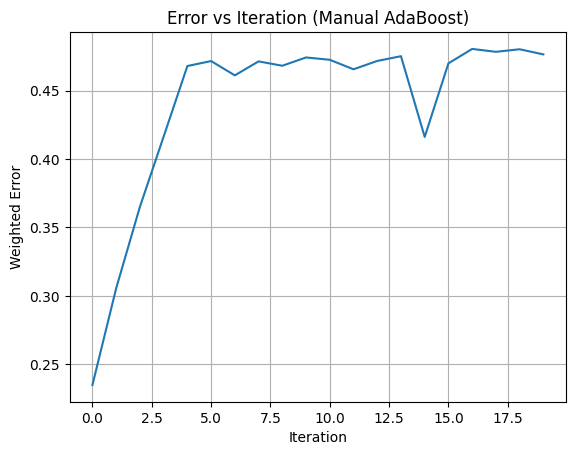

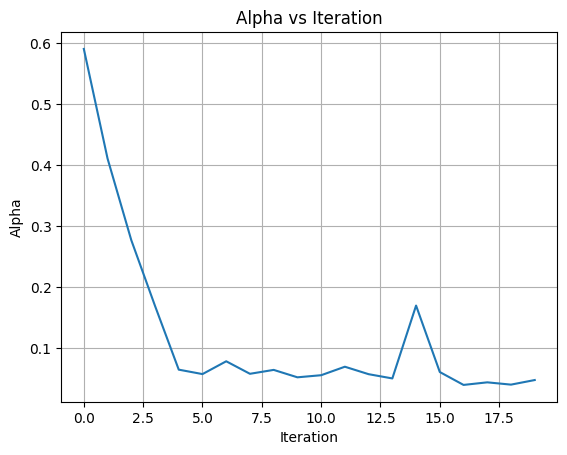

In [32]:
plt.plot(errors)
plt.title("Error vs Iteration (Manual AdaBoost)")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.grid(True)
plt.show()

plt.plot(alphas)
plt.title("Alpha vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.grid(True)
plt.show()